第7回の演習です。OpenCVを使って画像処理を行います。
左上の「ファイル」＞「ドライブにコピーを保存」を選択して、Google DriveにNotebookを保存します。ご自身のGoogleドライブの"Colab Notebooks"フォルダで、保存したNotebookを右クリックし、「アプリで開く」＞「Google Colaboratory」を選択します。その上で、各コードを実行するには、以下のコマンドを実行してください。実行は「再生」ボタンを押します。

In [ ]:
print("Chapter 7")

Chapter 7


ファイル読み込み

In [ ]:
from google.colab import files
# ファイルのアップロード
uploaded = files.upload()
# 画像のファイル名を取得
image_filenames = list(uploaded.keys())           # 辞書型をリスト型に変換
image_filename = image_filenames[0]               # リストの最初の要素（行）を取り出す
print("ファイル名：", image_filename)

Saving manapi02a.png to manapi02a.png
ファイル名： manapi02a.png


事前準備

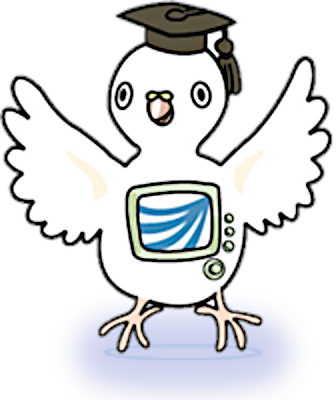

In [ ]:
# OpenCVを使う準備
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

cv_img = cv2.imread(image_filename)
cv2_imshow(cv_img)

## エッジ抽出
エッジ抽出は、画像の中の画素値が大きく変化する部分を抽出します。ここではCanny関数を使います。Canny法はJohn F. Cannyによって開発されたエッジ検出アルゴリズムです。基本的に、(1)雑音抑制、(2)画素値勾配の検出という2つの処理から構成されます。ただし、2つの工夫があります。1つは、非最大（極大）抑制を使うことです。これは勾配の検出を行うとき、エッジ上の注目点が、エッジに垂直な勾配方向上の点に対して極大値であるかどうかを確認します。もう一つは、ヒステリシスを使った閾値処理です。

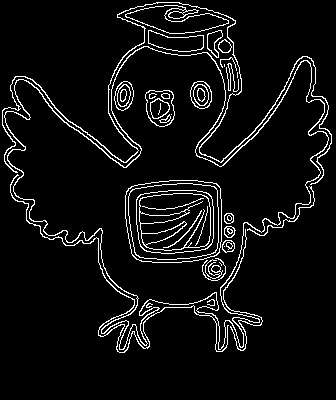

In [ ]:
# エッジ抽出
gray_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)
edge_img = cv2.Canny(gray_img,100,200)
cv2_imshow(edge_img)

## Harrisのコーナー検出
画像の特徴点を抽出するという観点から見ると、エッジ検出では不十分でした。コーナーを検出しなければいけません。Harrisのコーナー検出器はC. Harris & M. Stephensによって開発され、多用されてきました。OpenCVにはcornerHarris関数が用意されており、簡単に実装できます。

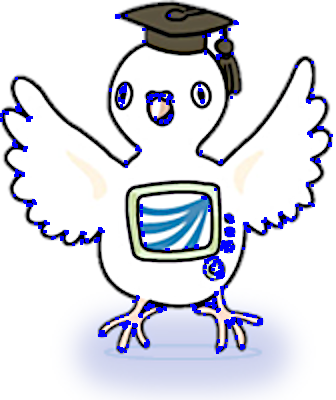

In [ ]:
# Harrisのコーナー検出器
# 画像読み込み
cv_img = cv2.imread(image_filename)
# 元画像のグレースケール変換
gray_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)

gray = np.float32(gray_img)
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

# コーナーとして検出したけど、重要じゃないところは削除
dst1 = cv2.dilate(dst,None)

# 最適な閾値を求める（画像に依存する）
cv_img[dst1 > 0.01 * dst1.max()]=[255, 0, 0]

# cv2.imshow('dst1',img)
cv2_imshow(cv_img)

## goodFeaturesToTrack
OpenCVにはコーナー検出器としてgoodFeaturesToTrackという関数が備えられています。これは、先のHarrisのコーナー検出器とShi-Tomashiの手法に多少の改良を加えたものです。

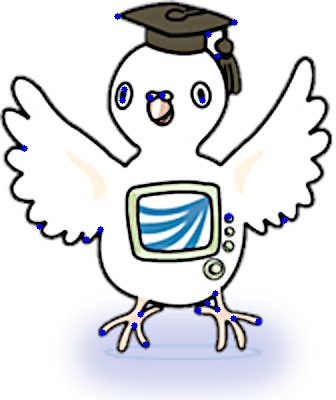

In [ ]:
# goodFeaturesToTrack
# 画像読み込み
cv_img = cv2.imread(image_filename)
# 元画像のグレースケール変換
gray_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)

# コーナー検出
corners = cv2.goodFeaturesToTrack(gray_img, 25, 0.01, 10)
corners1 = np.int_(corners)

# 特徴点を元画像に反映
for i in corners1:
    x, y = i.ravel()
    cv2.circle(cv_img, (x, y), 3, 255, -1)

# 特徴点を元画像に反映させた画像を作成
cv2_imshow(cv_img)

## FASTアルゴリズム
実時間アプリケーションを想定したコーナー検出器としてFASTがあります。画像中の画素の連続性と機械学習によって高速処理を可能にしています。

Total Keypoints with nonmaxSuppression:  183


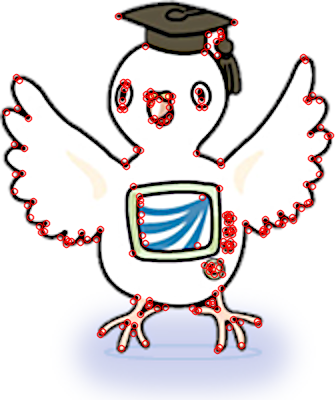

Total Keypoints without nonmaxSuppression:  708


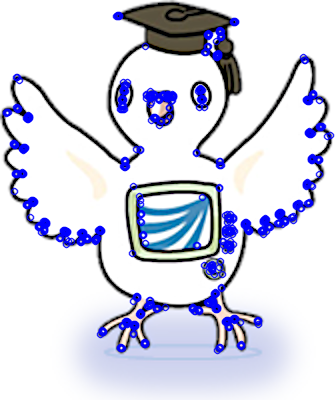

In [ ]:
# FASTアルゴリズム
# 画像読み込み
cv_img = cv2.imread(image_filename)
# cv2_imshow(cv_img)

# FASTオブジェクトを初期化
# fast = cv2.FastFeatureDetector_create()
fast = cv2.FastFeatureDetector_create(100, True)

# キーポイントを探索して描画
kp = fast.detect(cv_img, None)
# img2 = cv2.drawKeypoints(cv_img, kp, color=(255,0,0))
img2 = cv_img.copy()
for k in kp:
    pt = np.int32(k.pt)
    cv2.circle(img2, (pt[0],pt[1]), 3, (0,0,255), 1,lineType=cv2.LINE_AA)

# 初期パラメータを表示
# print("Threashold: ", fast.getThreshold())
# print("nonmaxSupression: ", fast.getNonmaxSuppression())
# print("neighborhood: ", fast.getType())

print("Total Keypoints with nonmaxSuppression: ", len(kp))

cv2_imshow(img2)

# 非最大抑制を無効にする
# fast.setBool("nonmaxSuppression", 0)
fast.setNonmaxSuppression(0)
kp = fast.detect(cv_img, None)

print("Total Keypoints without nonmaxSuppression: ", len(kp))

img3 = cv2.drawKeypoints(cv_img, kp, None, color=(255,0,0))

cv2_imshow(img3)

## ORB (Oriented FAST and rotated BRIEF)
ORBはE. Rubleeらによって開発された特徴抽出器です。基本的に、FASTによる特徴点検出とBRIEFによる特徴量記述子との組み合わせになっています。まず、FASTによって特徴点を検出し、Harrisのコーナー適合度によってコーナーらしいものを選択します。イメージピラミッドを使って、マルチスケールの特徴を取得します。特徴ベクトルの記述にはBRIEFに回転不変性を付与した改良版を使います。

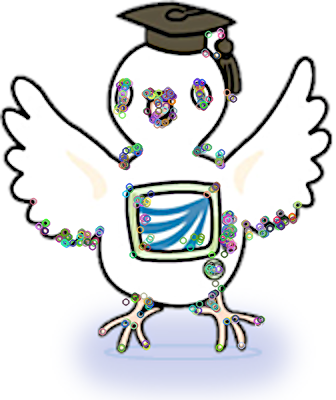

In [ ]:
# ORB
# 画像読み込み
cv_img = cv2.imread(image_filename)

# STAR検出器を初期化
# orb = cv2.ORB()
orb = cv2.ORB_create()

# ORBでキーポイントを探索
kp = orb.detect(cv_img, None)

# ORBで記述子を算出
kp, des = orb.compute(cv_img, kp)

# draw only keypoints location,not size and orientation
# img2 = cv2.drawKeypoints(cv_img, kp, color = (255, 0, 0), flags=0)
img2 = cv2.drawKeypoints(cv_img, kp, cv_img)

cv2_imshow(img2)